# MLP for TF Function

In [321]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

## Data

In [322]:
# Load data
freq_data = np.genfromtxt("TTF_freq.csv")

# Load pickle
with open(r"Results\TTF_data.pt", "rb") as f:
    TTF_data = pickle.load(f)

with open(r"Results\Vs_values.pt", "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

print(TTF_data.shape, Vs_data.shape, freq_data.shape)

(500, 256) (500, 30) (256,)


In [323]:
# Use only certain freq
idx = 190
freq = freq_data[idx]
print(freq, idx)

1.0174393797989472 190


In [324]:
# Separate the 10 values randomly for testing
test_indices = np.random.choice(len(TTF_data), 10, replace=False)
test_TTF_data = TTF_data[test_indices][:, idx]
test_Vs_data = Vs_data[test_indices]

train_indices = np.delete(np.arange(len(TTF_data)), test_indices)
train_TTF_data = TTF_data[train_indices][:, idx]
train_Vs_data = Vs_data[train_indices]

print("Training data size: " ,train_TTF_data.shape, train_Vs_data.shape)
print("Testing data size: ", test_TTF_data.shape, test_Vs_data.shape)

Training data size:  (490,) (490, 30)
Testing data size:  (10,) (10, 30)


In [325]:
class TTFDataset(Dataset):
    def __init__(self, TTF_data, Vs_array, freq_array):
        self.TTF_data = TTF_data
        self.Vs_array = Vs_array
        self.freq_array = freq_array

    def __len__(self):
        return len(self.TTF_data)

    def __getitem__(self, idx):

        # Input 
        Vs = self.Vs_array[:,idx]
        freq = self.freq_array[idx] * np.ones(1)
        input_data = np.concatenate((Vs, freq))
        input_data = torch.tensor(input_data, dtype=torch.float32)

        # Target
        TTF = self.TTF_data[idx] * np.ones(1)
        target = torch.tensor(TTF, dtype=torch.float32)

        return input_data, target

In [326]:
from sklearn.preprocessing import StandardScaler

scaler_Vs = StandardScaler()
scaler_TTF = StandardScaler()
scaler_freq = StandardScaler()

Vs_values = scaler_Vs.fit_transform(train_Vs_data.T)
TTF_values = scaler_TTF.fit_transform(train_TTF_data.reshape(-1, 1))
freq_values = scaler_freq.fit_transform(freq.reshape(-1, 1))

In [327]:
freq_values = (freq_values * np.ones(Vs_values.shape[1])).reshape(-1)

In [328]:
# Create dataset
dataset = TTFDataset(TTF_values, Vs_values, freq_values)

In [329]:
# Separate into training and testing
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " ,train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

i_batch_size = 200
train_loader = DataLoader(train_dataset, batch_size=i_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=i_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=i_batch_size, shuffle=True)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Train, validation and test sizes:  392 49 49
Number of batches:  2 1 1


## Model

In [330]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [331]:
# Create TF model
class TF_model(nn.Module):
    def __init__(self, input_dim=31, output_dim=1):
        super(TF_model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fmlp1 = MLP(input_dim-1, 30, 2, output_dim=1, activation=nn.ReLU)
        self.fmlp2 = MLP(2, 32, 2, output_dim=1, activation=nn.ReLU)

    def forward(self, x):
        x1 = x[:, :-1]
        x2 = x[:, -1].unsqueeze(1) 
        x1 = self.fmlp1(x1)
        x = torch.stack((x1, x2), dim=1).squeeze(2)
        x = self.fmlp2(x)
        return x


Preliminary check if the shapes are correct

In [332]:
model = MLP(31, 30, 2, output_dim=1, activation=nn.Sigmoid)
loss_fn = nn.MSELoss()
X,y = next(iter(train_loader))
print(X.shape, y.shape)
pred = model(X)
assert pred.shape == y.shape , f"Expected shape {y.shape} but got {pred.shape}"
print("Loss: ", loss_fn(pred, y))

torch.Size([200, 31]) torch.Size([200, 1])
Loss:  tensor(1.0338, grad_fn=<MseLossBackward0>)


## Training

Defining the Early Stopping to avoid redudant training if the loss is not decreasing.

In [333]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

### Training function

In [334]:
import torch
from tqdm import tqdm, trange
import torch.nn as nn
import numpy as np

def train(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", patience=50):
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model

### Testing function

In [335]:
# Define test function
def test(model, test_dataloader, loss_fn, device="cpu"):
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

## Start of Training

In [336]:
# Device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [337]:
# Model
model = MLP(31, 30, 4, output_dim=1, activation=nn.ReLU, batch_norm=False)
#model = TF_model()

# Xavier Glore initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# Loss function - RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = rmse

In [338]:
# Optimizer with momentum NAG
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.01, nesterov=True)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.05, alpha=0.9, eps=1e-08, weight_decay=0.01, momentum=0.9, centered=False)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)


# Scheduler with exponential decay
#scheduler = None
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=250, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-4, eps=1e-08)

In [339]:
# Train model
train_losses, val_losses, model = train(model, optimizer, scheduler, train_loader, val_loader, loss_fn, epochs=10000, device=device, patience=1500)

Training:   0%|          | 7/10000 [00:00<04:51, 34.33epoch/s, EarlyStopping counter: 5 out of 1500]

Epoch 0, Train Loss: 0.9344436228275299, Val Loss: 1.156038522720337, LR: 0.05


Training:   1%|          | 106/10000 [00:03<05:45, 28.65epoch/s, EarlyStopping counter: 103 out of 1500]

Epoch 100, Train Loss: 0.6563840806484222, Val Loss: 1.2295225858688354, LR: 0.05


Training:   2%|▏         | 203/10000 [00:06<06:10, 26.41epoch/s, EarlyStopping counter: 203 out of 1500]

Epoch 200, Train Loss: 0.660482257604599, Val Loss: 1.2738492488861084, LR: 0.05


Training:   3%|▎         | 305/10000 [00:10<05:38, 28.67epoch/s, EarlyStopping counter: 303 out of 1500]

Epoch 300, Train Loss: 0.6235044896602631, Val Loss: 1.2915630340576172, LR: 0.025


Training:   4%|▍         | 404/10000 [00:13<05:36, 28.54epoch/s, EarlyStopping counter: 403 out of 1500]

Epoch 400, Train Loss: 0.6197774112224579, Val Loss: 1.295786738395691, LR: 0.025


Training:   5%|▌         | 505/10000 [00:17<05:10, 30.60epoch/s, EarlyStopping counter: 504 out of 1500]

Epoch 500, Train Loss: 0.6311100721359253, Val Loss: 1.2927907705307007, LR: 0.025


Training:   6%|▌         | 606/10000 [00:20<05:09, 30.34epoch/s, EarlyStopping counter: 603 out of 1500]

Epoch 600, Train Loss: 0.6081128120422363, Val Loss: 1.2876194715499878, LR: 0.0125


Training:   7%|▋         | 706/10000 [00:24<05:27, 28.39epoch/s, EarlyStopping counter: 704 out of 1500]

Epoch 700, Train Loss: 0.6069876551628113, Val Loss: 1.2936209440231323, LR: 0.0125


Training:   8%|▊         | 805/10000 [00:27<05:16, 29.03epoch/s, EarlyStopping counter: 803 out of 1500]

Epoch 800, Train Loss: 0.6013298332691193, Val Loss: 1.2956725358963013, LR: 0.00625


Training:   9%|▉         | 904/10000 [00:30<05:03, 29.98epoch/s, EarlyStopping counter: 904 out of 1500]

Epoch 900, Train Loss: 0.6050965785980225, Val Loss: 1.2966411113739014, LR: 0.00625


Training:  10%|█         | 1003/10000 [00:34<05:05, 29.41epoch/s, EarlyStopping counter: 1003 out of 1500]

Epoch 1000, Train Loss: 0.6012484133243561, Val Loss: 1.2934006452560425, LR: 0.00625


Training:  11%|█         | 1105/10000 [00:37<05:04, 29.17epoch/s, EarlyStopping counter: 1103 out of 1500]

Epoch 1100, Train Loss: 0.6020002067089081, Val Loss: 1.2925021648406982, LR: 0.003125


Training:  12%|█▏        | 1206/10000 [00:41<05:03, 29.02epoch/s, EarlyStopping counter: 1203 out of 1500]

Epoch 1200, Train Loss: 0.5713682174682617, Val Loss: 1.2953370809555054, LR: 0.003125


Training:  13%|█▎        | 1305/10000 [00:44<05:10, 28.02epoch/s, EarlyStopping counter: 1303 out of 1500]

Epoch 1300, Train Loss: 0.5846440196037292, Val Loss: 1.2973016500473022, LR: 0.0015625


Training:  14%|█▍        | 1405/10000 [00:48<05:00, 28.58epoch/s, EarlyStopping counter: 1403 out of 1500]

Epoch 1400, Train Loss: 0.6007467806339264, Val Loss: 1.2947992086410522, LR: 0.0015625


Training:  15%|█▌        | 1502/10000 [00:51<04:51, 29.12epoch/s, EarlyStopping counter: 1500 out of 1500]

Epoch 1500, Train Loss: 0.5778495967388153, Val Loss: 1.2966922521591187, LR: 0.0015625
Early stopping


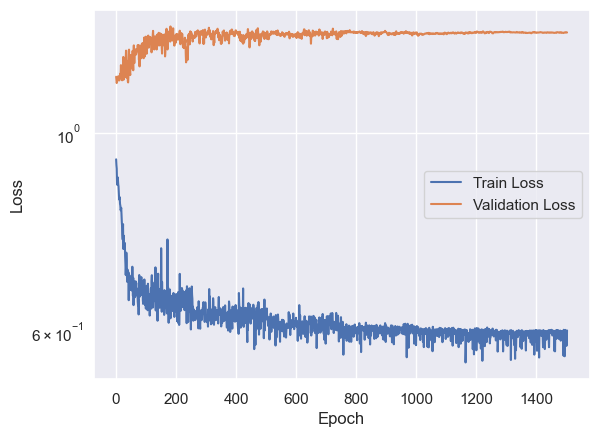

In [340]:
# Plot losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [341]:
# Test the model
test_loss = test(model, test_loader, loss_fn, device=device)
print("Test loss: ", test_loss)

Test loss:  1.145573377609253


## Check the model

In [342]:
def denormalize_data(data, mean, std):
    return data * std + mean

In [343]:
# Predict and plot
model.eval()
predictions = []
target = []
Vs_target = []
freq_target = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        predictions.append(y_pred.cpu().numpy())
        target.append(y.cpu().numpy()) 
        Vs_target.append(X[:, :-1].cpu().numpy())
        freq_target.append(X[:, -1].cpu().numpy())


predictions = np.concatenate(predictions)
target = np.concatenate(target)
Vs_target = np.concatenate(Vs_target)
freq_target = np.concatenate(freq_target)


In [344]:
# Denormalize
freq_target = scaler_freq.inverse_transform(freq_target.reshape(-1, 1)).flatten()

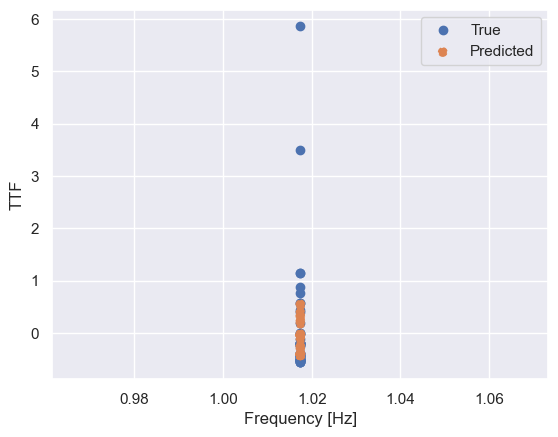

In [345]:
plt.scatter(freq_target, target, label="True")
plt.scatter(freq_target, predictions, label="Predicted", linestyle="--")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("TTF")
plt.show()


In [346]:
# Save the model
#torch.save(model.state_dict(), "MLP_TF_model.pth")